In [26]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
from lightning.pytorch.tuner import Tuner
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

In [27]:
warnings.filterwarnings("ignore", message=".*does not have valid feature names.*")

In [28]:
data_path = "./DTFL - Data/352-Table 1.csv"

max_encoder_length = 4 * 10
max_prediction_length = 4 * 2

lr = 3e-4
epochs = 5
batch_size = 128

In [29]:
df = pd.read_csv(data_path)
df["room_id"] = df["room_id"].astype(str)
df["hours"] = df["hours"].astype(str)
df["days"] = df["days"].astype(str)
df["months"] = df["months"].astype(str)
for col in ["temprature_value", "humidity_value", "co2_value"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.sort_values(["room_id", "timestamp"]).reset_index(drop=True)
df["time_idx"] = df.groupby("room_id").cumcount()
training_cutoff = df["time_idx"].max() - max_prediction_length

In [30]:
df = df.replace([np.inf, -np.inf], np.nan)
for col in ["temprature_value", "humidity_value", "co2_value"]:
    df[col] = df[col].interpolate(method="linear")

In [31]:
train_dataset = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=["temprature_value", "humidity_value", "co2_value"],
    group_ids=["room_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["room_id"],
    static_reals=["area", "doors_area", "panels_area"],
    time_varying_known_categoricals=["hours", "days", "months"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["temprature_value", "humidity_value", "co2_value"],
    target_normalizer=MultiNormalizer([
        EncoderNormalizer(method='standard',center=True,max_length=None,transformation=None,method_kwargs={}),
        EncoderNormalizer(method='standard',center=True,max_length=None,transformation=None,method_kwargs={}),
        EncoderNormalizer(method='standard',center=True,max_length=None,transformation=None,method_kwargs={})
    ]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size)

val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset, df, predict=True, stop_randomization=True
)
val_dataloader = val_dataset.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [32]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)

/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/trainer/connect

In [33]:
targets = ["temprature_value", "humidity_value", "co2_value"]
outputs = baseline_predictions.output
y = baseline_predictions.y

for i in range(len(targets)):
    print(f"{targets[i]}: {MAE()(outputs[i], y[0][i])}")

temprature_value: 0.26579856872558594
humidity_value: 0.29609203338623047
co2_value: 11.111854553222656


In [34]:
model = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=lr,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    loss=MAE(),
    output_size=[1, 1, 1],
    log_interval=10,
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {model.size() / 1e3:.1f}k")

/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 26.7k


In [35]:
trainer = pl.Trainer(
    accelerator="cpu",
    gradient_clip_val=0.1
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
Finding best initial lr:  93%|█████████▎| 93/100 [00:18<00:01,  4.98it/s]
LR finder stopped early 

suggested learning rate: 0.057543993733715736


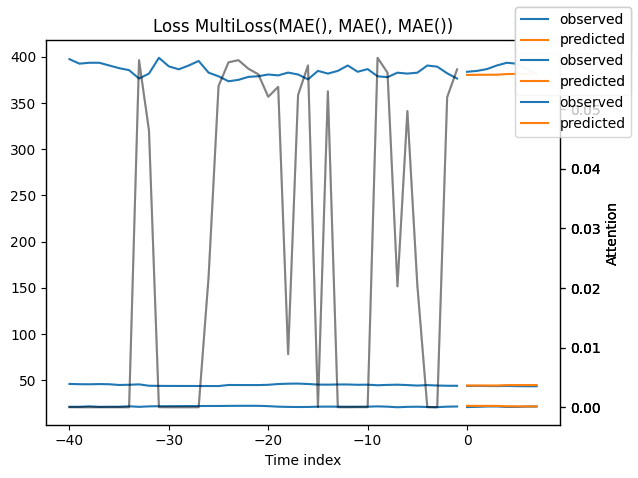

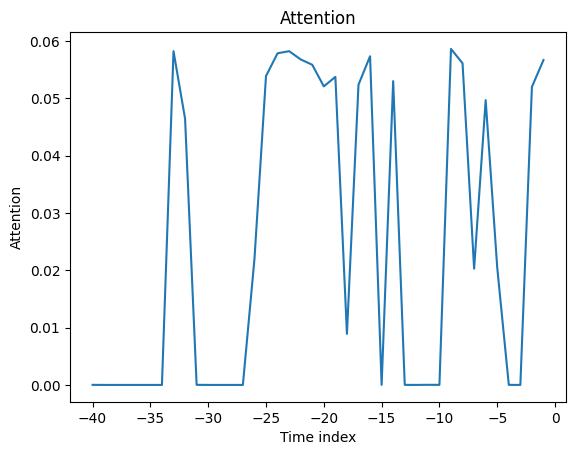

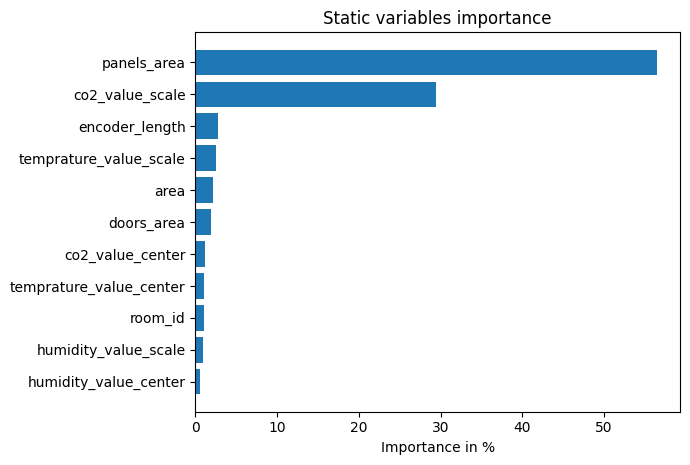

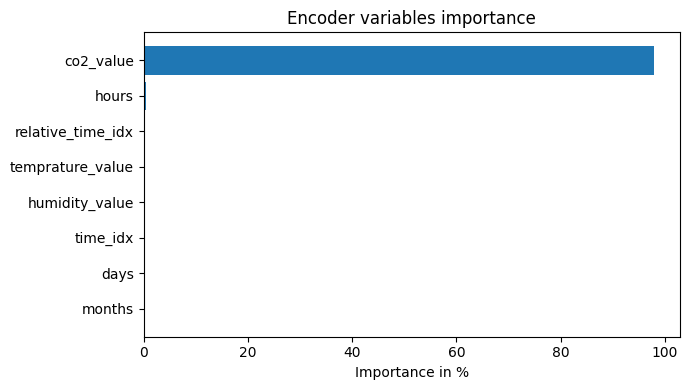

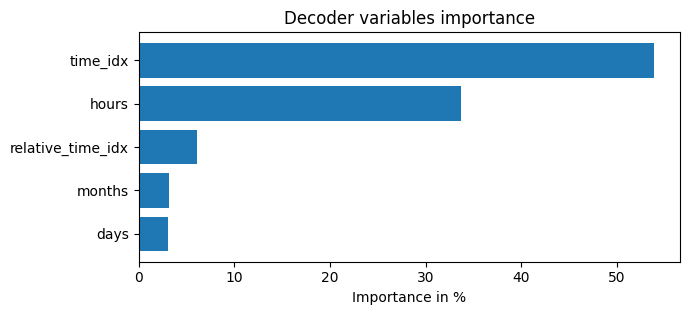

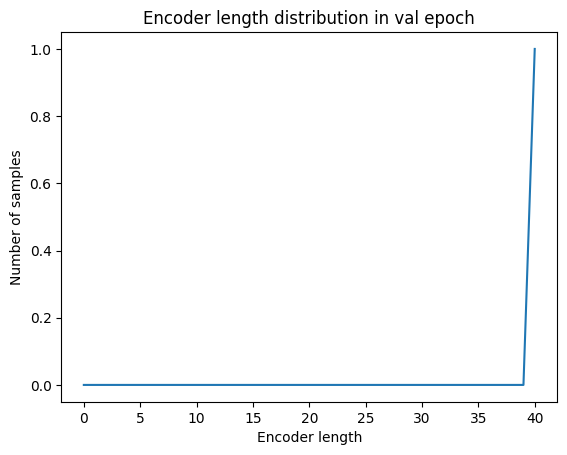

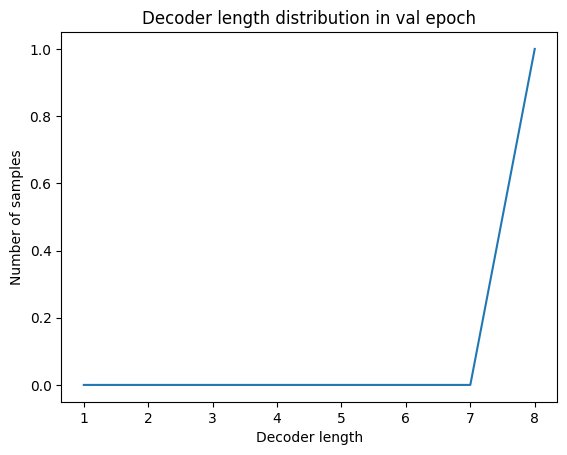

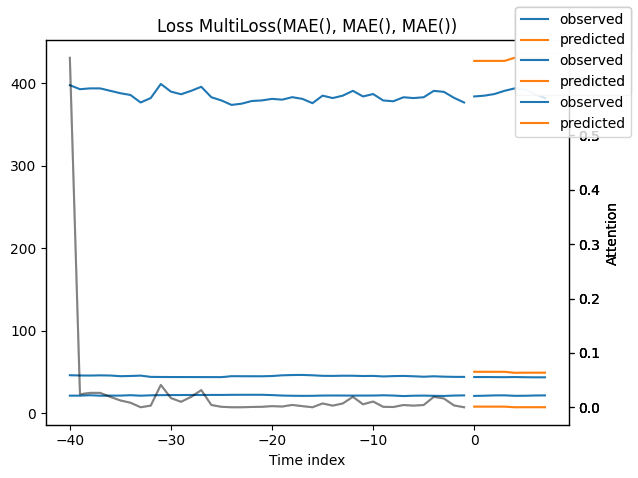

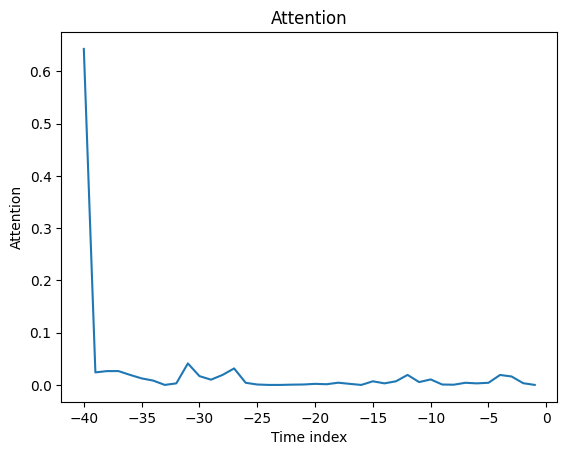

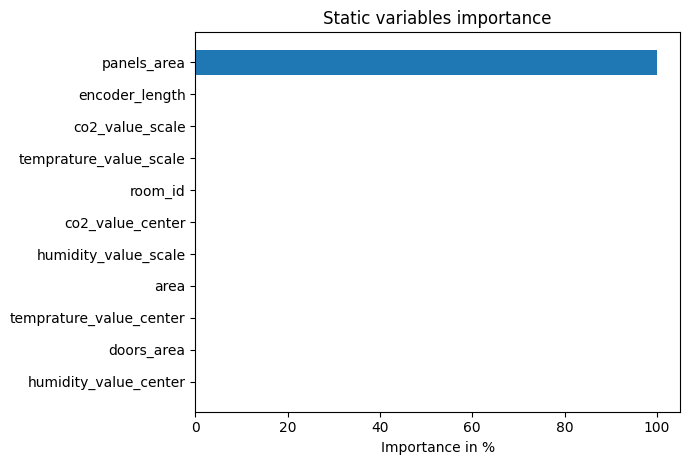

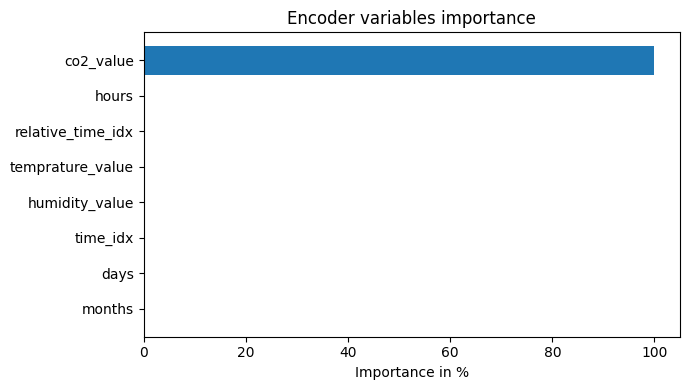

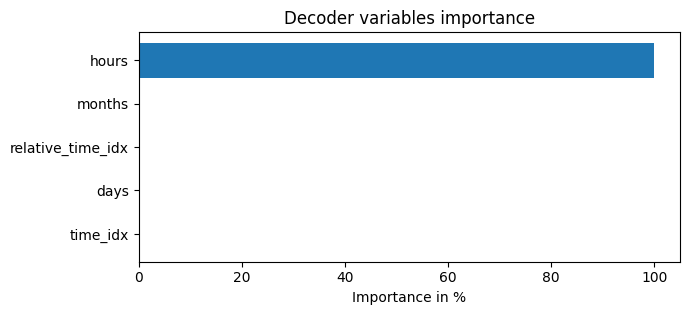

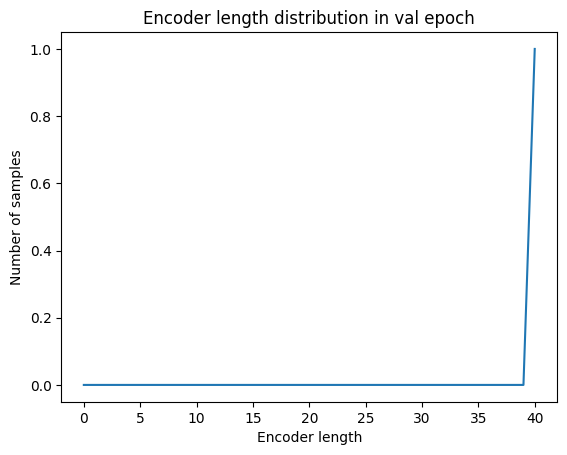

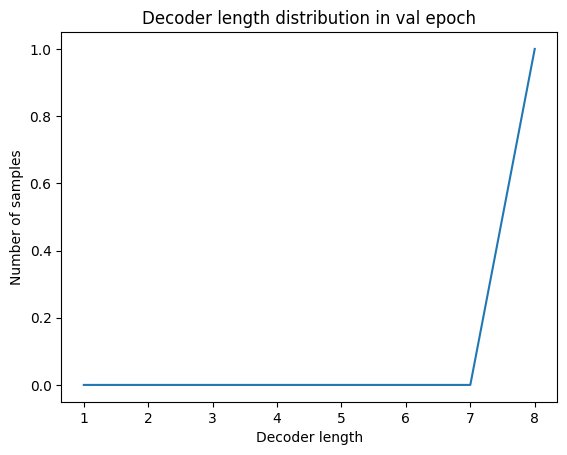

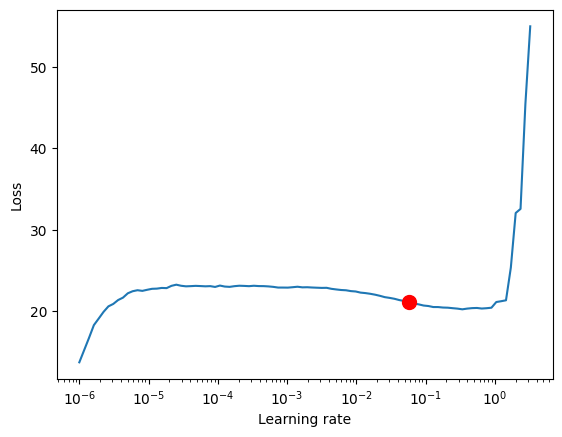

/var/folders/fc/9w7nbmnj2y10_sl912glk3240000gn/T/ipykernel_17901/2919332599.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [36]:
res = Tuner(trainer).lr_find(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [37]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=3,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [38]:
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 570    | train
3  | prescalers                         | ModuleDict                      | 240    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 6.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.6 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/amirrezasokhankhosh/mambaforge/envs/flask/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 50/50 [00:24<00:00,  2.08it/s, v_num=1, train_loss_step=12.70, val_loss=10.10, train_loss_epoch=14.50]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s, v_num=1, train_loss_step=12.70, val_loss=10.10, train_loss_epoch=14.50]


In [39]:
trainer.checkpoint_callback.best_model_path

'lightning_logs/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt'